# Creating a Median Composite with Dask

## Introduction

When working with optical satellite imagery, one of the first pre-processing step is to apply a cloud-mask on individual satellite scenes and create a cloud-free composite image for the chosen time period. Doing this in the traditional way requires you to download large satellite scenes, read them into memory and iteratively process them. This is not very efficient and does not leverage all the resources your computer has to offer. We can instead leverage modern cloud-native data formats, such a *Cloud-Optimized GeoTIFFs* (COGs) that can efficiently stream only the required pixels, process the time-series of scenes using *XArray* that uses vectorized operations to efficiently process the whole stack, and use *Dask* to run the computation in parallel across all the CPU cores. This modern approach makes data processing tasks easy, efficient and fun.

## Overview of the Task

We will query a STAC catalog for Sentinel-2 imagery over the city of Bengaluru, India, apply a cloud-mask and create a median composite image using distributed processing on a local machine.


**Input Layers**:

* `bangalore.geojson`: A GeoJSON file representing the municipal boundary for the city of Bengaluru, India.

**Output Layers**:
*   `composite.tif` : A Cloud-optimized GeoTIFF (COG) of Sentinel-2 composite image for January 2025.

**Data Credit**:
* Bangalore Ward Maps Provided by Spatial Data of Municipalities (Maps) Project by Data{Meet}.
* Sentinel-2 Level 2A Scenes: Contains modified Copernicus Sentinel data (2025-02)

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install pystac-client odc-stac rioxarray dask jupyter-server-proxy

In [21]:
from odc.stac import stac_load
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pystac_client
import rioxarray as rxr
import xarray as xr

In [22]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [23]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'
filename = 'bangalore.geojson'

download(data_url + filename)

Setup a local Dask cluster. This distributes the computation across multiple workers on your computer.

> Note: If you are running this notebook in Colab, you will not be able to access the Daskboard link.

In [ ]:
from dask.distributed import Client, progress
client = Client()  # set up local cluster on the machine
client

## Search and Load Sentinel-2 Scenes

Read the file containing the city boundary.

In [24]:
aoi_file = 'bangalore.geojson'
aoi_filepath = os.path.join(data_folder, aoi_file)
aoi = gpd.read_file(aoi_filepath)

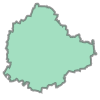

In [25]:
geometry = aoi.geometry.union_all()
geometry

Let's use Element84 search endpoint to look for items from the `sentinel-2-c1-l2a` collection on AWS. We search for the imagery collected within the date range and intersecting the AOI geometry.

We also specify additonal filters to select scenes based on metadata. The parameter `eo:cloud_cover` contains the overall cloud percentage and we use it to select imagery with < 30% overall cloud cover. Our region of interest has overlapping scenes from multiple MGRS grid tiles, so we can specify an additional filter to select tiles only from one of the grids. You will need to update this for your region of interest.

In [26]:
catalog = pystac_client.Client.open(
    'https://earth-search.aws.element84.com/v1')

In [27]:
year = 2025
month = 1
time_range = f'{year}-{month:02}'

filters = {
    'eo:cloud_cover': {'lt': 30},
    'mgrs:grid_square': {'eq': 'GQ'}
}

search = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    intersects=geometry,
    datetime=time_range,
    query=filters,
)
items = search.item_collection()
len(items)

4

Load the matching images as a XArray Dataset.

In [10]:
ds = stac_load(
    items,
    bands=['red', 'green', 'blue', 'scl'],
    resolution=10,
    bbox=geometry.bounds,
    chunks={},  # <-- use Dask
    groupby='solar_day',
)
ds

<xarray.Dataset> Size: 345MB
Dimensions:      (y: 3465, x: 3553, time: 4)
Coordinates:
  * y            (y) float64 28kB 1.455e+06 1.455e+06 ... 1.42e+06 1.42e+06
  * x            (x) float64 28kB 7.667e+05 7.667e+05 ... 8.022e+05 8.022e+05
    spatial_ref  int32 4B 32643
  * time         (time) datetime64[ns] 32B 2025-01-07T05:25:20.058000 ... 202...
Data variables:
    red          (time, y, x) uint16 98MB dask.array<chunksize=(1, 3465, 3553), meta=np.ndarray>
    green        (time, y, x) uint16 98MB dask.array<chunksize=(1, 3465, 3553), meta=np.ndarray>
    blue         (time, y, x) uint16 98MB dask.array<chunksize=(1, 3465, 3553), meta=np.ndarray>
    scl          (time, y, x) uint8 49MB dask.array<chunksize=(1, 3465, 3553), meta=np.ndarray>

We first convert the Dataset it to a DataArray using the `to_array()` method. All the variables will be converted to a new dimension. Since our variables are image bands, we give the name of the new dimesion as `band`.

In [11]:
da = ds.to_array('band')
da

<xarray.DataArray (band: 4, time: 4, y: 3465, x: 3553)> Size: 394MB
dask.array<stack, shape=(4, 4, 3465, 3553), dtype=uint16, chunksize=(1, 1, 3465, 3553), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 28kB 1.455e+06 1.455e+06 ... 1.42e+06 1.42e+06
  * x            (x) float64 28kB 7.667e+05 7.667e+05 ... 8.022e+05 8.022e+05
    spatial_ref  int32 4B 32643
  * time         (time) datetime64[ns] 32B 2025-01-07T05:25:20.058000 ... 202...
  * band         (band) object 32B 'red' 'green' 'blue' 'scl'

## Apply a Cloud Mask

Use the `SCL` (Scene Classification Map) band to select non-cloud pixels and use XArray .where() to mask cloudy pixels. XArray uses a vectorized operation to apply the condition across the entire stack of scenes using their corresponding SCL bands - without neededing to iterate over each scene individually.

In [37]:
scl = da.sel(band='scl')

valid = ((scl >= 4) & (scl <= 7) | (scl==11))

da_masked = da.where(valid)

Visualize the original and masked image. Here we plot the first image in the time-series of both original and masked DataArrays side-by-side.

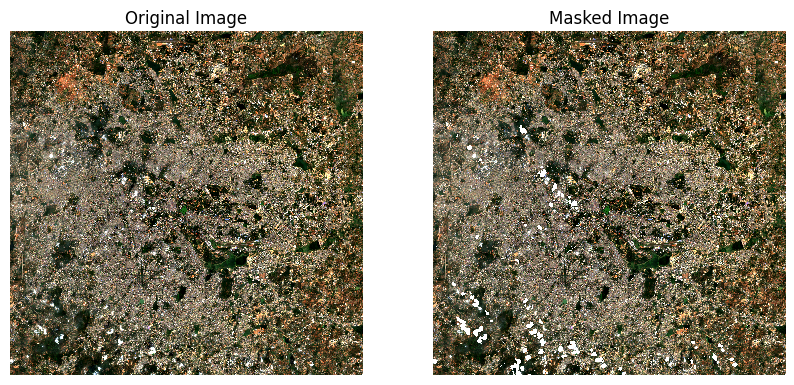

In [36]:
fig, (ax0, ax1) = plt.subplots(1, 2)
fig.set_size_inches(10,5)
da.isel(time=0).sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax0,
    robust=True)
ax0.set_title('Original Image')
ax0.set_axis_off()
ax0.set_aspect('equal')

da_masked.isel(time=0).sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax1,
    robust=True)
ax1.set_title('Masked Image')
ax1.set_axis_off()
ax1.set_aspect('equal')
plt.show()



## Create a Median Composite

A very-powerful feature of XArray is the ability to easily aggregate data across dimensions - making it ideal for many remote sensing analysis. Let’s create a median composite from all the individual images.

We apply the `.median()` aggregation across the time dimension.

In [38]:
rgb_composite = da_masked \
  .sel(band=['red', 'green', 'blue']) \
  .median(dim='time')
rgb_composite

<xarray.DataArray (band: 3, y: 3465, x: 3553)> Size: 148MB
dask.array<nanmedian, shape=(3, 3465, 3553), dtype=float32, chunksize=(1, 2860, 2932), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 28kB 1.455e+06 1.455e+06 ... 1.42e+06 1.42e+06
  * x            (x) float64 28kB 7.667e+05 7.667e+05 ... 8.022e+05 8.022e+05
    spatial_ref  int32 4B 32643
  * band         (band) object 24B 'red' 'green' 'blue'

So far all the operations that we have created a computation graph. To run this computation using the local Dask cluster, we must call `.compute()`.

In [14]:
%%time
rgb_composite = rgb_composite.compute()

CPU times: user 2.84 s, sys: 619 ms, total: 3.46 s
Wall time: 44.3 s


## Visualizing and Exporting the Results

The composite is creating from all the pixels within the bounding box of the geometry. We can use `rioxarray` to clip the image to the city boundary to remove pixels outside the polygon.

In [15]:
image_crs = rgb_composite.rio.crs
aoi_reprojected = aoi.to_crs(image_crs)
rgb_composite_clipped = rgb_composite.rio.clip(aoi_reprojected.geometry)

Plot the results.

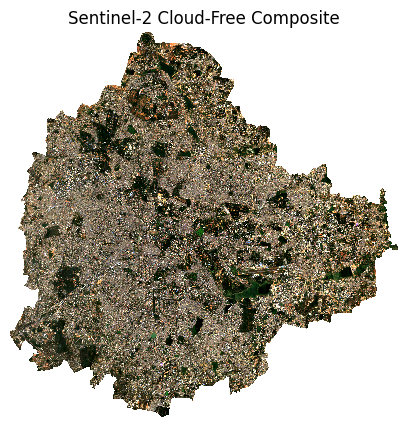

In [16]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
rgb_composite_clipped.sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('Sentinel-2 Cloud-Free Composite')
ax.set_axis_off()
plt.show()

We finally save the results as a local Cloud-Optimized GeoTIFF file.

In [ ]:
output_file = f'composite.tif'
output_path = os.path.join(output_folder, output_file)
rgb_composite_clipped.rio.to_raster(output_path, driver='COG')
print(f'Wrote {output_file}')